# Libraries

In [1]:
import os
import time
import random

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts, MultiStepLR
import torch.nn.init as init
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(27)

# Dataset

In [4]:
def unpickle(file):
    """
    Loads the data from the pickle file
    """
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
BASE_DIR = "../input/cifar10-python/cifar-10-batches-py"

In [6]:
# Load the CIFAR-10 dataset
data = np.empty((0, 3072))
labels = []
for i in range(1,6):
    path = os.path.join(BASE_DIR, f"data_batch_{i}")
    dict = unpickle(path)
    data = np.vstack((data, dict[b'data']))
    labels.extend(dict[b'labels'])

In [7]:
# Split the training data into train and validation sets
train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels, test_size=0.1, random_state=42)

In [8]:
class CifarDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = np.transpose(data.reshape(data.shape[0], 3, 32, 32), (0, 2, 3, 1))/255
        
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.data[idx])
        else:
            image = torch.tensor(self.data[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

In [9]:
transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Pad(4, padding_mode='reflect'),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomCrop(32),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

In [10]:
train_dataset = CifarDataset(train_data, train_labels, transform_train)
valid_dataset = CifarDataset(valid_data, valid_labels, transform_test)

In [11]:
def show_img(x):
    """
    Display image and label
    """
    img, label = x
    print(label)
    plt.imshow(torch.permute(img, (1,2,0)))

tensor(6)


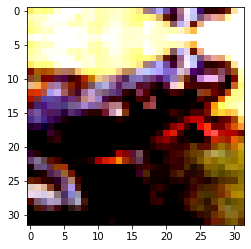

In [12]:
show_img(train_dataset[90])

In [13]:
# Load the test dataset
path = os.path.join(BASE_DIR, f"test_batch")
dict = unpickle(path)
data = dict[b'data']
labels = dict[b'labels']

In [14]:
test_dataset = CifarDataset(data, labels, transform_test)

# Model

In [15]:
# Code for Wide Residual Networks with Modified Forward Pass

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out1 = self.block1(out)
        out2 = self.block2(out1)
        out3 = self.block3(out2)
        out = self.relu(self.bn1(out3))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        # forward pass is modified to output intermediate features
        return self.fc(out), out1, out2, out3

In [16]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=False)

teacher_model = WideResNet(16, 10, 2)
student_model = WideResNet(16, 10, 1)

teacher_model.to(device)
student_model.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(

In [17]:
# load the pretrained teacher model and freeze the parameters
teacher_model.load_state_dict(torch.load('../input/wideresnetweights/wrn-16-2-(94.02).pt'))
for param in teacher_model.parameters():
    param.requires_grad = False

# Attention Transfer Loss

In [19]:
class AttentionTransferLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    @staticmethod
    def attention_map(feature_map):
        """
        Compute the attention map from a feature map.
        """
        return F.normalize(feature_map.pow(2).mean(1).flatten(1))

    def compute_loss(self, teacher_feature_map, student_feature_map):
        """
        Compute the loss between teacher and student feature maps.
        """
        teacher_attention_map = self.attention_map(teacher_feature_map)
        student_attention_map = self.attention_map(student_feature_map)
        loss = (teacher_attention_map - student_attention_map).pow(2).mean()
        return loss
    
    def forward(self, feature_map_pairs):
        """
        feature_map_pairs: list of (teacher_feature_map, student_feature_map)
        """
        loss = 0
        batch_size = feature_map_pairs[0][0].size(0)
        for (teacher_feature_map, student_feature_map) in feature_map_pairs:
            loss += self.compute_loss(teacher_feature_map, student_feature_map)
        return loss

# Helper Function

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [21]:
def train_fn(train_loader, teacher_model, student_model, criterion1, criterion2, beta, optimizer, device):
    """
    Training a single epoch

    Parameters
    ----------
    train_loader : DataLoader
    teacher_model : Trained teacher model
    student_model : Model to be trained by distillation
    criterion1: CrossEntropyLoss
    criterion2: AttentionTransferLoss
    beta: Weight for the attention loss
    optimizer : optimizer for student_model
    device : torch.device

    Returns
    -------
    ce_loss: Average CrossEntropyLoss
    at_loss: Average AttentionTransferLoss (weighted by beta)
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    ce_losses = AverageMeter()
    at_losses = AverageMeter()

    student_model.train()
    teacher_model.eval()
    
    start = end = time.time()
    for step, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        batch_size = labels.size(0)

        teacher_preds = teacher_model(images)
        student_preds = student_model(images)
        
        loss1 = criterion1(student_preds[0], labels)
        feature_map_pairs = [(teacher_preds[1], student_preds[1]),
                             (teacher_preds[2], student_preds[2]),
                             (teacher_preds[3], student_preds[3])]
        loss2 = criterion2(feature_map_pairs)
        loss = loss1 + beta*loss2
        
        ce_losses.update(loss1.item(), batch_size)
        at_losses.update(loss2.item(), batch_size)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_time.update(time.time() - end)
        end = time.time()

    return ce_losses.avg, beta*at_losses.avg

def valid_fn(test_loader, teacher_model, student_model, criterion1, criterion2, beta, device):
    """
    Validate after training an epoch

    Parameters
    ----------
    train_loader : DataLoader
    teacher_model : Trained teacher model
    student_model : Model to be trained by distillation
    criterion1: CrossEntropyLoss
    criterion2: AttentionTransferLoss
    beta: Weight for the attention loss
    optimizer : optimizer for student_model
    device : torch.device

    Returns
    -------
    ce_loss: Average CrossEntropyLoss
    at_loss: Average AttentionTransferLoss (weighted by beta)
    score: Accuracy score
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    ce_losses = AverageMeter()
    at_losses = AverageMeter()

    teacher_model.eval()
    student_model.eval()
    
    start = end = time.time()
    preds = []
    valid_labels = []
    for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            teacher_preds = teacher_model(images)
            student_preds = student_model(images)
        
        loss1 = criterion1(student_preds[0], labels)
        feature_map_pairs = [(teacher_preds[1], student_preds[1]),
                             (teacher_preds[2], student_preds[2]),
                             (teacher_preds[3], student_preds[3])]
        loss2 = criterion2(feature_map_pairs)
        loss = loss1 + beta*loss2
        
        ce_losses.update(loss1.item(), batch_size)
        at_losses.update(loss2.item(), batch_size)

        preds.append(student_preds[0].softmax(1).to('cpu').numpy())
        valid_labels.append(labels.to('cpu').numpy())
        
        batch_time.update(time.time() - end)
        end = time.time()

    predictions = np.concatenate(preds)
    valid_labels = np.concatenate(valid_labels)
    
    score = get_score(valid_labels, predictions.argmax(1))
    
    return ce_losses.avg, beta*at_losses.avg, score

# Training

In [22]:
ce_loss = nn.CrossEntropyLoss()
at_loss = AttentionTransferLoss()
optimizer = SGD(student_model.parameters(), lr=1e-1, momentum=0.9, weight_decay=0.0005, nesterov=True)
scheduler = MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-01.


In [23]:
best_score = 0

for epoch in range(200):
    start_time = time.time()
    
    # Train
    avg_loss1, avg_loss2 = train_fn(train_loader, teacher_model, student_model, ce_loss, at_loss, 1000, optimizer, device)
    # Validate
    avg_val_loss1, avg_val_loss2, score = valid_fn(valid_loader, teacher_model, student_model, ce_loss, at_loss, 1000, device)

    scheduler.step()
    
    print(f"Epoch {epoch+1}")
    print(f"Accuracy: {score} | Train loss: {avg_loss1+avg_loss2} | Valid loss: {avg_val_loss1+avg_val_loss2}")
    print(f"Train CE Loss: {avg_loss1} Valid CE Loss: {avg_val_loss1}")
    print(f"Train AT Loss: {avg_loss2} Valid AT Loss: {avg_val_loss2}")
    
    if score > best_score:
        # Save the model if the validation score is better
        print("YES")
        best_score = score
        torch.save(student_model.state_dict(), f"best_model.pt")
        
    elapsed = time.time() - start_time

100%|██████████| 40/40 [00:00<00:00, 41.99it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1
Accuracy: 0.573 | Train loss: 3.3481400360047817 | Valid loss: 2.8164502617806195
Train CE Loss: 1.4661971489800347 Valid CE Loss: 1.195566471004486
Train AT Loss: 1.881942887024747 Valid AT Loss: 1.6208837907761335
YES



100%|██████████| 40/40 [00:00<00:00, 42.89it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2
Accuracy: 0.7082 | Train loss: 2.4208735769435763 | Valid loss: 2.292973284164071
Train CE Loss: 0.9333672476132711 Valid CE Loss: 0.8358667620658875
Train AT Loss: 1.4875063293303052 Valid AT Loss: 1.4571065220981836
YES



100%|██████████| 40/40 [00:00<00:00, 41.24it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3
Accuracy: 0.668 | Train loss: 2.088855086546805 | Valid loss: 2.3909078056827187
Train CE Loss: 0.7480403856171502 Valid CE Loss: 0.98445677318573
Train AT Loss: 1.340814700929655 Valid AT Loss: 1.4064510324969888



100%|██████████| 40/40 [00:01<00:00, 33.29it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4
Accuracy: 0.7108 | Train loss: 1.9134969060387876 | Valid loss: 2.2219427325755357
Train CE Loss: 0.6558882500330607 Valid CE Loss: 0.9068368514060974
Train AT Loss: 1.257608656005727 Valid AT Loss: 1.3151058811694385
YES



100%|██████████| 40/40 [00:00<00:00, 44.56it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5
Accuracy: 0.7532 | Train loss: 1.7970017450427016 | Valid loss: 2.0447439127117395
Train CE Loss: 0.6015388059616089 Valid CE Loss: 0.7695783157348632
Train AT Loss: 1.1954629390810927 Valid AT Loss: 1.2751655969768763
YES



100%|██████████| 40/40 [00:00<00:00, 43.22it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6
Accuracy: 0.7698 | Train loss: 1.7044078207126923 | Valid loss: 1.9301456646874549
Train CE Loss: 0.556984284485711 Valid CE Loss: 0.6912968709945678
Train AT Loss: 1.1474235362269813 Valid AT Loss: 1.238848793692887
YES



100%|██████████| 40/40 [00:01<00:00, 36.41it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7
Accuracy: 0.775 | Train loss: 1.6428999867230654 | Valid loss: 1.873694704128802
Train CE Loss: 0.5331365980148316 Valid CE Loss: 0.6746661039352417
Train AT Loss: 1.1097633887082337 Valid AT Loss: 1.1990286001935602
YES



100%|██████████| 40/40 [00:00<00:00, 45.29it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8
Accuracy: 0.7974 | Train loss: 1.591000389794343 | Valid loss: 1.768803203892708
Train CE Loss: 0.5077868859079149 Valid CE Loss: 0.5992845036506653
Train AT Loss: 1.0832135038864281 Valid AT Loss: 1.1695187002420426
YES



100%|██████████| 40/40 [00:00<00:00, 44.41it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 9
Accuracy: 0.7378 | Train loss: 1.5447358937280047 | Valid loss: 2.091656895814836
Train CE Loss: 0.48556569756401907 Valid CE Loss: 0.8849259334564209
Train AT Loss: 1.0591701961639857 Valid AT Loss: 1.2067309623584153



100%|██████████| 40/40 [00:00<00:00, 43.68it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 10
Accuracy: 0.7614 | Train loss: 1.5159083111413652 | Valid loss: 1.8804285279229283
Train CE Loss: 0.4731261994891697 Valid CE Loss: 0.7205829252243042
Train AT Loss: 1.0427821116521954 Valid AT Loss: 1.1598456026986241



100%|██████████| 40/40 [00:00<00:00, 42.99it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 11
Accuracy: 0.7818 | Train loss: 1.485927365579787 | Valid loss: 1.8332398222476243
Train CE Loss: 0.4599092918078105 Valid CE Loss: 0.642514863395691
Train AT Loss: 1.0260180737719766 Valid AT Loss: 1.1907249588519333



100%|██████████| 40/40 [00:00<00:00, 43.21it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 12
Accuracy: 0.793 | Train loss: 1.4693939909798401 | Valid loss: 1.7829592967152594
Train CE Loss: 0.45346796973546344 Valid CE Loss: 0.6659553477287292
Train AT Loss: 1.0159260212443768 Valid AT Loss: 1.1170039489865302



100%|██████████| 40/40 [00:01<00:00, 33.82it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 13
Accuracy: 0.8008 | Train loss: 1.4389945389910705 | Valid loss: 1.7052986120164393
Train CE Loss: 0.43802100795639887 Valid CE Loss: 0.6030027997970581
Train AT Loss: 1.0009735310346717 Valid AT Loss: 1.1022958122193813
YES



100%|██████████| 40/40 [00:00<00:00, 42.39it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 14
Accuracy: 0.7962 | Train loss: 1.4348877876915038 | Valid loss: 1.7333014486320317
Train CE Loss: 0.4401645345634884 Valid CE Loss: 0.6293766790032387
Train AT Loss: 0.9947232531280154 Valid AT Loss: 1.103924769628793



100%|██████████| 40/40 [00:01<00:00, 34.19it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 15
Accuracy: 0.8354 | Train loss: 1.4115569207866987 | Valid loss: 1.5685616567552088
Train CE Loss: 0.42960498486624826 Valid CE Loss: 0.4887370101928711
Train AT Loss: 0.9819519359204505 Valid AT Loss: 1.0798246465623378
YES



100%|██████████| 40/40 [00:00<00:00, 42.99it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 16
Accuracy: 0.7648 | Train loss: 1.3969538546709552 | Valid loss: 1.8322415789350868
Train CE Loss: 0.41970153925153947 Valid CE Loss: 0.7579816251754761
Train AT Loss: 0.9772523154194157 Valid AT Loss: 1.0742599537596107



100%|██████████| 40/40 [00:01<00:00, 35.40it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 17
Accuracy: 0.815 | Train loss: 1.390677236209727 | Valid loss: 1.6616324730336665
Train CE Loss: 0.4211742027070787 Valid CE Loss: 0.5648789689064025
Train AT Loss: 0.9695030335026483 Valid AT Loss: 1.096753504127264



100%|██████████| 40/40 [00:00<00:00, 44.30it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 18
Accuracy: 0.8158 | Train loss: 1.3791269136238429 | Valid loss: 1.6482335993833839
Train CE Loss: 0.415442028564877 Valid CE Loss: 0.5855921697616577
Train AT Loss: 0.9636848850589659 Valid AT Loss: 1.0626414296217261



100%|██████████| 40/40 [00:00<00:00, 42.18it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 19
Accuracy: 0.7658 | Train loss: 1.3678263108458784 | Valid loss: 1.8512493834033608
Train CE Loss: 0.40806449565887454 Valid CE Loss: 0.7506214073061943
Train AT Loss: 0.9597618151870039 Valid AT Loss: 1.1006279760971664



100%|██████████| 40/40 [00:01<00:00, 36.32it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 20
Accuracy: 0.8294 | Train loss: 1.356469242238833 | Valid loss: 1.6132527162343264
Train CE Loss: 0.4058256012545692 Valid CE Loss: 0.5170285941123962
Train AT Loss: 0.9506436409842637 Valid AT Loss: 1.0962241221219302



100%|██████████| 40/40 [00:00<00:00, 42.99it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 21
Accuracy: 0.8094 | Train loss: 1.3543944906291863 | Valid loss: 1.7104650783985855
Train CE Loss: 0.402997497733434 Valid CE Loss: 0.6046207375526428
Train AT Loss: 0.9513969928957522 Valid AT Loss: 1.1058443408459426



100%|██████████| 40/40 [00:01<00:00, 39.39it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 22
Accuracy: 0.8202 | Train loss: 1.3465407715155846 | Valid loss: 1.618766309577227
Train CE Loss: 0.40038741607401107 Valid CE Loss: 0.5656995246887208
Train AT Loss: 0.9461533554415735 Valid AT Loss: 1.053066784888506



100%|██████████| 40/40 [00:01<00:00, 33.00it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 23
Accuracy: 0.8076 | Train loss: 1.3400605922720499 | Valid loss: 1.7083666091397407
Train CE Loss: 0.3988595726331075 Valid CE Loss: 0.6098226610183716
Train AT Loss: 0.9412010196389424 Valid AT Loss: 1.098543948121369



100%|██████████| 40/40 [00:00<00:00, 44.27it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 24
Accuracy: 0.8262 | Train loss: 1.3332119644214708 | Valid loss: 1.5790391130939125
Train CE Loss: 0.39568130598598056 Valid CE Loss: 0.519678789806366
Train AT Loss: 0.9375306584354903 Valid AT Loss: 1.0593603232875466



100%|██████████| 40/40 [00:00<00:00, 43.30it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 25
Accuracy: 0.8076 | Train loss: 1.3276204452243945 | Valid loss: 1.7193442816257478
Train CE Loss: 0.39077394478585986 Valid CE Loss: 0.6342366630554199
Train AT Loss: 0.9368465004385346 Valid AT Loss: 1.085107618570328



100%|██████████| 40/40 [00:00<00:00, 42.54it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 26
Accuracy: 0.77 | Train loss: 1.321449385574129 | Valid loss: 1.8244446408256887
Train CE Loss: 0.38853398875130546 Valid CE Loss: 0.7259717634201049
Train AT Loss: 0.9329153968228234 Valid AT Loss: 1.0984728774055839



100%|██████████| 40/40 [00:01<00:00, 34.25it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 27
Accuracy: 0.74 | Train loss: 1.3181051974231996 | Valid loss: 1.9852467499509454
Train CE Loss: 0.3924120580514272 Valid CE Loss: 0.8826593233108521
Train AT Loss: 0.9256931393717726 Valid AT Loss: 1.1025874266400935



100%|██████████| 40/40 [00:00<00:00, 42.08it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 28
Accuracy: 0.8114 | Train loss: 1.3088355543934638 | Valid loss: 1.6628435943335294
Train CE Loss: 0.3837756058216095 Valid CE Loss: 0.6118732743024826
Train AT Loss: 0.9250599485718543 Valid AT Loss: 1.0509703200310467



100%|██████████| 40/40 [00:00<00:00, 40.30it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 29
Accuracy: 0.7138 | Train loss: 1.3088019051419364 | Valid loss: 2.1348546646803617
Train CE Loss: 0.38382219688097635 Valid CE Loss: 1.0277440797805786
Train AT Loss: 0.92497970826096 Valid AT Loss: 1.107110584899783



100%|██████████| 40/40 [00:01<00:00, 34.87it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 30
Accuracy: 0.7902 | Train loss: 1.3081118478065563 | Valid loss: 1.6897079130016266
Train CE Loss: 0.3856211352719201 Valid CE Loss: 0.6362080825805664
Train AT Loss: 0.9224907125346362 Valid AT Loss: 1.0534998304210603



100%|██████████| 40/40 [00:01<00:00, 37.25it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 31
Accuracy: 0.8366 | Train loss: 1.2975032380286189 | Valid loss: 1.5254977810099724
Train CE Loss: 0.37686500448120963 Valid CE Loss: 0.4940952018737793
Train AT Loss: 0.9206382335474094 Valid AT Loss: 1.031402579136193
YES



100%|██████████| 40/40 [00:00<00:00, 40.68it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 32
Accuracy: 0.7414 | Train loss: 1.302329966276553 | Valid loss: 2.034494628533721
Train CE Loss: 0.3822436390399933 Valid CE Loss: 0.8788195961713791
Train AT Loss: 0.9200863272365597 Valid AT Loss: 1.155675032362342



100%|██████████| 40/40 [00:01<00:00, 32.17it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 33
Accuracy: 0.8352 | Train loss: 1.2969592520539959 | Valid loss: 1.538345274579525
Train CE Loss: 0.37966534842915006 Valid CE Loss: 0.5023230421066284
Train AT Loss: 0.9172939036248459 Valid AT Loss: 1.0360222324728965



100%|██████████| 40/40 [00:00<00:00, 40.49it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 34
Accuracy: 0.803 | Train loss: 1.2920919638896982 | Valid loss: 1.6985596317246556
Train CE Loss: 0.37511086461279125 Valid CE Loss: 0.598282687497139
Train AT Loss: 0.9169810992769069 Valid AT Loss: 1.1002769442275167



100%|██████████| 40/40 [00:01<00:00, 29.82it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 35
Accuracy: 0.8282 | Train loss: 1.2880470455841058 | Valid loss: 1.5719213290669023
Train CE Loss: 0.3769806272877587 Valid CE Loss: 0.5199858111858368
Train AT Loss: 0.911066418296347 Valid AT Loss: 1.0519355178810657



100%|██████████| 40/40 [00:00<00:00, 44.74it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 36
Accuracy: 0.8348 | Train loss: 1.2837076465335986 | Valid loss: 1.5253678988114
Train CE Loss: 0.373523016972012 Valid CE Loss: 0.4908661888360977
Train AT Loss: 0.9101846295615865 Valid AT Loss: 1.0345017099753022



100%|██████████| 40/40 [00:01<00:00, 35.61it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 37
Accuracy: 0.7844 | Train loss: 1.2877345422069233 | Valid loss: 1.7207247555300595
Train CE Loss: 0.3738692764600118 Valid CE Loss: 0.6498353721618653
Train AT Loss: 0.9138652657469114 Valid AT Loss: 1.0708893833681943



100%|██████████| 40/40 [00:00<00:00, 42.85it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 38
Accuracy: 0.8548 | Train loss: 1.2788055037336217 | Valid loss: 1.4792063336417078
Train CE Loss: 0.3711498555501302 Valid CE Loss: 0.43411720819473265
Train AT Loss: 0.9076556481834915 Valid AT Loss: 1.0450891254469752
YES



100%|██████████| 40/40 [00:00<00:00, 43.65it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 39
Accuracy: 0.8038 | Train loss: 1.2817076643375058 | Valid loss: 1.657317789453268
Train CE Loss: 0.37218396626048617 Valid CE Loss: 0.6051038024902343
Train AT Loss: 0.9095236980770197 Valid AT Loss: 1.0522139869630336



100%|██████████| 40/40 [00:00<00:00, 43.76it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 40
Accuracy: 0.8226 | Train loss: 1.27838358509375 | Valid loss: 1.5252481527999042
Train CE Loss: 0.37142907445960577 Valid CE Loss: 0.5264587646722794
Train AT Loss: 0.9069545106341442 Valid AT Loss: 0.998789388127625



100%|██████████| 40/40 [00:00<00:00, 44.01it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 41
Accuracy: 0.8488 | Train loss: 1.2756983838124407 | Valid loss: 1.4568726474530993
Train CE Loss: 0.3693097254859077 Valid CE Loss: 0.4642380339205265
Train AT Loss: 0.9063886583265331 Valid AT Loss: 0.9926346135325729



100%|██████████| 40/40 [00:00<00:00, 43.02it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 42
Accuracy: 0.8336 | Train loss: 1.272924262887405 | Valid loss: 1.5468601891174911
Train CE Loss: 0.36746637167400786 Valid CE Loss: 0.53925155544281
Train AT Loss: 0.9054578912133971 Valid AT Loss: 1.0076086336746812



100%|██████████| 40/40 [00:00<00:00, 40.74it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 43
Accuracy: 0.8202 | Train loss: 1.2698098489434355 | Valid loss: 1.5903393064290285
Train CE Loss: 0.36455200905799867 Valid CE Loss: 0.5749144808053971
Train AT Loss: 0.9052578398854368 Valid AT Loss: 1.0154248256236316



100%|██████████| 40/40 [00:00<00:00, 45.21it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 44
Accuracy: 0.8216 | Train loss: 1.2687637393810682 | Valid loss: 1.5895676309756936
Train CE Loss: 0.36650885247654386 Valid CE Loss: 0.5511053645566106
Train AT Loss: 0.9022548869045245 Valid AT Loss: 1.038462266419083



100%|██████████| 40/40 [00:01<00:00, 35.77it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 45
Accuracy: 0.8586 | Train loss: 1.27226448521523 | Valid loss: 1.4285735648989677
Train CE Loss: 0.36992655965487165 Valid CE Loss: 0.4333103996634483
Train AT Loss: 0.9023379255603585 Valid AT Loss: 0.9952631652355194
YES



100%|██████████| 40/40 [00:00<00:00, 44.29it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 46
Accuracy: 0.8344 | Train loss: 1.2594699761202766 | Valid loss: 1.5091117260560392
Train CE Loss: 0.3609378461201986 Valid CE Loss: 0.49334911774396895
Train AT Loss: 0.898532130000078 Valid AT Loss: 1.0157626083120703



100%|██████████| 40/40 [00:00<00:00, 46.69it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 47
Accuracy: 0.8176 | Train loss: 1.2607293400883675 | Valid loss: 1.5860359095394614
Train CE Loss: 0.3622873980522156 Valid CE Loss: 0.520821803098917
Train AT Loss: 0.8984419420361519 Valid AT Loss: 1.0652141064405443



100%|██████████| 40/40 [00:01<00:00, 35.27it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 48
Accuracy: 0.8238 | Train loss: 1.266518768454757 | Valid loss: 1.574398212838173
Train CE Loss: 0.3644794487847222 Valid CE Loss: 0.5688314459800721
Train AT Loss: 0.9020393196700348 Valid AT Loss: 1.005566766858101



100%|██████████| 40/40 [00:00<00:00, 43.66it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 49
Accuracy: 0.8492 | Train loss: 1.2652312490688429 | Valid loss: 1.4512837149962783
Train CE Loss: 0.3658629091262817 Valid CE Loss: 0.44576014008522036
Train AT Loss: 0.8993683399425613 Valid AT Loss: 1.0055235749110578



100%|██████████| 40/40 [00:00<00:00, 42.17it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 50
Accuracy: 0.7634 | Train loss: 1.2619436122771766 | Valid loss: 1.8299546028107405
Train CE Loss: 0.3615297709782918 Valid CE Loss: 0.7651965244293213
Train AT Loss: 0.9004138412988848 Valid AT Loss: 1.0647580783814192



100%|██████████| 40/40 [00:00<00:00, 44.95it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 51
Accuracy: 0.8276 | Train loss: 1.2537769673926964 | Valid loss: 1.56263095536679
Train CE Loss: 0.3589221312681834 Valid CE Loss: 0.5107595962047576
Train AT Loss: 0.8948548361245129 Valid AT Loss: 1.0518713591620326



100%|██████████| 40/40 [00:01<00:00, 30.29it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 52
Accuracy: 0.8114 | Train loss: 1.2554814611232943 | Valid loss: 1.6264828773379327
Train CE Loss: 0.36012404045528834 Valid CE Loss: 0.5673299955368042
Train AT Loss: 0.8953574206680059 Valid AT Loss: 1.0591528818011284



100%|██████████| 40/40 [00:00<00:00, 42.98it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 53
Accuracy: 0.8264 | Train loss: 1.256799261743327 | Valid loss: 1.5431191298991442
Train CE Loss: 0.3597804224279192 Valid CE Loss: 0.5235862776517868
Train AT Loss: 0.8970188393154078 Valid AT Loss: 1.0195328522473575



100%|██████████| 40/40 [00:00<00:00, 44.42it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 54
Accuracy: 0.7986 | Train loss: 1.2576418033925196 | Valid loss: 1.6695235171392562
Train CE Loss: 0.36409419629308915 Valid CE Loss: 0.622580023765564
Train AT Loss: 0.8935476070994305 Valid AT Loss: 1.046943493373692



100%|██████████| 40/40 [00:00<00:00, 41.27it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 55
Accuracy: 0.7618 | Train loss: 1.2547203701951437 | Valid loss: 1.7658206937253473
Train CE Loss: 0.36275289248360526 Valid CE Loss: 0.7106673215866088
Train AT Loss: 0.8919674777115384 Valid AT Loss: 1.0551533721387385



100%|██████████| 40/40 [00:00<00:00, 42.48it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 56
Accuracy: 0.8568 | Train loss: 1.2520969808461766 | Valid loss: 1.4322496135354044
Train CE Loss: 0.35729449213875664 Valid CE Loss: 0.41971077961921693
Train AT Loss: 0.8948024887074199 Valid AT Loss: 1.0125388339161874



100%|██████████| 40/40 [00:00<00:00, 42.29it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 57
Accuracy: 0.8102 | Train loss: 1.2498848352217011 | Valid loss: 1.6099117847919464
Train CE Loss: 0.3577205262713962 Valid CE Loss: 0.5937732252120972
Train AT Loss: 0.892164308950305 Valid AT Loss: 1.0161385595798493



100%|██████████| 40/40 [00:01<00:00, 36.87it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 58
Accuracy: 0.82 | Train loss: 1.24907695321598 | Valid loss: 1.5836730095386504
Train CE Loss: 0.3585514568063948 Valid CE Loss: 0.5517236086368561
Train AT Loss: 0.8905254964095851 Valid AT Loss: 1.0319494009017944



100%|██████████| 40/40 [00:00<00:00, 41.25it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 59
Accuracy: 0.8298 | Train loss: 1.250648248009218 | Valid loss: 1.541217026284337
Train CE Loss: 0.3615519514719645 Valid CE Loss: 0.5154086006641387
Train AT Loss: 0.8890962965372535 Valid AT Loss: 1.0258084256201982



100%|██████████| 40/40 [00:00<00:00, 42.88it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 60
Accuracy: 0.8422 | Train loss: 1.2405126000901892 | Valid loss: 1.4444030737660825
Train CE Loss: 0.35523882251050737 Valid CE Loss: 0.45903662509918214
Train AT Loss: 0.8852737775796817 Valid AT Loss: 0.9853664486669004



100%|██████████| 40/40 [00:01<00:00, 35.80it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 61
Accuracy: 0.9064 | Train loss: 1.015765873186373 | Valid loss: 1.0835465299479663
Train CE Loss: 0.25509209672080146 Valid CE Loss: 0.2789609126329422
Train AT Loss: 0.7606737764655715 Valid AT Loss: 0.8045856173150241
YES



100%|██████████| 40/40 [00:01<00:00, 39.38it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 62
Accuracy: 0.8994 | Train loss: 0.9520624034658902 | Valid loss: 1.104798938741535
Train CE Loss: 0.22383324982325237 Valid CE Loss: 0.30775465717315675
Train AT Loss: 0.7282291536426378 Valid AT Loss: 0.7970442815683783



100%|██████████| 40/40 [00:01<00:00, 33.70it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 63
Accuracy: 0.9058 | Train loss: 0.9379790996508466 | Valid loss: 1.0674895377203821
Train CE Loss: 0.2172224907822079 Valid CE Loss: 0.27629105777740476
Train AT Loss: 0.7207566088686387 Valid AT Loss: 0.7911984799429774



100%|██████████| 40/40 [00:00<00:00, 42.39it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 64
Accuracy: 0.9008 | Train loss: 0.9344967817690637 | Valid loss: 1.0968445399880409
Train CE Loss: 0.21851760649946 Valid CE Loss: 0.29554556851387026
Train AT Loss: 0.7159791752696036 Valid AT Loss: 0.8012989714741707



100%|██████████| 40/40 [00:00<00:00, 43.88it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 65
Accuracy: 0.9076 | Train loss: 0.9295742664444777 | Valid loss: 1.0834771452568472
Train CE Loss: 0.21293596188227334 Valid CE Loss: 0.2824307694196701
Train AT Loss: 0.7166383045622043 Valid AT Loss: 0.8010463758371771
YES



100%|██████████| 40/40 [00:01<00:00, 39.61it/s]


Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 66
Accuracy: 0.9022 | Train loss: 0.9210440219896536 | Valid loss: 1.100591513492167
Train CE Loss: 0.2079851781845093 Valid CE Loss: 0.29542707109451294
Train AT Loss: 0.7130588438051443 Valid AT Loss: 0.8051644423976541


100%|██████████| 40/40 [00:01<00:00, 32.43it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 67
Accuracy: 0.8946 | Train loss: 0.9202637278490595 | Valid loss: 1.1331654065981507
Train CE Loss: 0.205712927558687 Valid CE Loss: 0.3227155536174774
Train AT Loss: 0.7145508002903725 Valid AT Loss: 0.8104498529806733



100%|██████████| 40/40 [00:00<00:00, 42.80it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 68
Accuracy: 0.8964 | Train loss: 0.918451586694436 | Valid loss: 1.1092416759565473
Train CE Loss: 0.20610292554696402 Valid CE Loss: 0.30962156299352644
Train AT Loss: 0.712348661147472 Valid AT Loss: 0.7996201129630208



100%|██████████| 40/40 [00:00<00:00, 43.83it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 69
Accuracy: 0.904 | Train loss: 0.9186613873857592 | Valid loss: 1.1010601747497917
Train CE Loss: 0.20518848661846584 Valid CE Loss: 0.30222357788085935
Train AT Loss: 0.7134729007672933 Valid AT Loss: 0.7988365968689323



100%|██████████| 40/40 [00:01<00:00, 39.55it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 70
Accuracy: 0.9024 | Train loss: 0.9313653004599942 | Valid loss: 1.1151564833119512
Train CE Loss: 0.21233765167660185 Valid CE Loss: 0.29324058241844175
Train AT Loss: 0.7190276487833923 Valid AT Loss: 0.8219159008935094



100%|██████████| 40/40 [00:01<00:00, 32.00it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 71
Accuracy: 0.8952 | Train loss: 0.9213875241477456 | Valid loss: 1.1339593496926128
Train CE Loss: 0.20663115195963117 Valid CE Loss: 0.3242789065286517
Train AT Loss: 0.7147563721881144 Valid AT Loss: 0.8096804431639611



100%|██████████| 40/40 [00:00<00:00, 41.61it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 72
Accuracy: 0.8958 | Train loss: 0.9324941932277546 | Valid loss: 1.134816622875631
Train CE Loss: 0.21302022151152292 Valid CE Loss: 0.3194934080839157
Train AT Loss: 0.7194739717162317 Valid AT Loss: 0.8153232147917152



100%|██████████| 40/40 [00:01<00:00, 33.66it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 73
Accuracy: 0.89 | Train loss: 0.9251639830762313 | Valid loss: 1.1347823797881602
Train CE Loss: 0.20589157745308345 Valid CE Loss: 0.3225695616722107
Train AT Loss: 0.7192724056231479 Valid AT Loss: 0.8122128181159496



100%|██████████| 40/40 [00:00<00:00, 43.50it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 74
Accuracy: 0.8934 | Train loss: 0.9279612218697866 | Valid loss: 1.120433679575473
Train CE Loss: 0.20767685459984672 Valid CE Loss: 0.31494852516651156
Train AT Loss: 0.7202843672699398 Valid AT Loss: 0.8054851544089615



100%|██████████| 40/40 [00:01<00:00, 29.37it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 75
Accuracy: 0.896 | Train loss: 0.9338733552705083 | Valid loss: 1.1338872780755163
Train CE Loss: 0.20820729140175714 Valid CE Loss: 0.3259479570865631
Train AT Loss: 0.7256660638687511 Valid AT Loss: 0.8079393209889532



100%|██████████| 40/40 [00:00<00:00, 44.10it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 76
Accuracy: 0.8874 | Train loss: 0.929646411444164 | Valid loss: 1.1826246147669852
Train CE Loss: 0.2069545356962416 Valid CE Loss: 0.344278311046958
Train AT Loss: 0.7226918757479225 Valid AT Loss: 0.8383463037200273



100%|██████████| 40/40 [00:01<00:00, 34.87it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 77
Accuracy: 0.8922 | Train loss: 0.936158326311244 | Valid loss: 1.167639274134487
Train CE Loss: 0.21052073136965435 Valid CE Loss: 0.3271716647624969
Train AT Loss: 0.7256375949415896 Valid AT Loss: 0.8404676093719899



100%|██████████| 40/40 [00:00<00:00, 44.19it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 78
Accuracy: 0.8856 | Train loss: 0.9424353616569605 | Valid loss: 1.1746541993051767
Train CE Loss: 0.21231898764239418 Valid CE Loss: 0.3330681304737926
Train AT Loss: 0.7301163740145663 Valid AT Loss: 0.8415860688313841



100%|██████████| 40/40 [00:00<00:00, 41.71it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 79
Accuracy: 0.8836 | Train loss: 0.9381035043017732 | Valid loss: 1.1615538959160445
Train CE Loss: 0.21232830644978418 Valid CE Loss: 0.34428848724365235
Train AT Loss: 0.7257751978519891 Valid AT Loss: 0.8172654086723923



100%|██████████| 40/40 [00:00<00:00, 41.78it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 80
Accuracy: 0.8896 | Train loss: 0.9290416040547191 | Valid loss: 1.1678148899100722
Train CE Loss: 0.20609704327318404 Valid CE Loss: 0.3439870004415512
Train AT Loss: 0.7229445607815351 Valid AT Loss: 0.8238278894685209



100%|██████████| 40/40 [00:01<00:00, 36.66it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 81
Accuracy: 0.8882 | Train loss: 0.9450241946321395 | Valid loss: 1.167902180580795
Train CE Loss: 0.2144699586364958 Valid CE Loss: 0.33235628924369814
Train AT Loss: 0.7305542359956437 Valid AT Loss: 0.8355458913370968



100%|██████████| 40/40 [00:00<00:00, 41.39it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 82
Accuracy: 0.8842 | Train loss: 0.933794558748934 | Valid loss: 1.1921743082284928
Train CE Loss: 0.2102921931664149 Valid CE Loss: 0.35408137016296387
Train AT Loss: 0.7235023655825191 Valid AT Loss: 0.8380929380655289



100%|██████████| 40/40 [00:01<00:00, 37.29it/s]


Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 83
Accuracy: 0.885 | Train loss: 0.9389002789037924 | Valid loss: 1.1767691240981222
Train CE Loss: 0.2111005062566863 Valid CE Loss: 0.3577235593795776
Train AT Loss: 0.727799772647106 Valid AT Loss: 0.8190455647185445


100%|██████████| 40/40 [00:01<00:00, 35.21it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 84
Accuracy: 0.876 | Train loss: 0.9329491784166959 | Valid loss: 1.217184524308145
Train CE Loss: 0.20876706890265148 Valid CE Loss: 0.3881051133155823
Train AT Loss: 0.7241821095140444 Valid AT Loss: 0.8290794109925628



100%|██████████| 40/40 [00:00<00:00, 44.12it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 85
Accuracy: 0.8852 | Train loss: 0.9425319507420891 | Valid loss: 1.1854943986579776
Train CE Loss: 0.21359536565144857 Valid CE Loss: 0.3577827823877335
Train AT Loss: 0.7289365850906405 Valid AT Loss: 0.8277116162702441



100%|██████████| 40/40 [00:01<00:00, 32.85it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 86
Accuracy: 0.8796 | Train loss: 0.9428509273154868 | Valid loss: 1.2055689948752524
Train CE Loss: 0.21518248850504557 Valid CE Loss: 0.3628761754512787
Train AT Loss: 0.7276684388104412 Valid AT Loss: 0.8426928194239736



100%|██████████| 40/40 [00:00<00:00, 42.62it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 87
Accuracy: 0.892 | Train loss: 0.9376239062446687 | Valid loss: 1.1704614798106252
Train CE Loss: 0.21010163273811341 Valid CE Loss: 0.3286570371627808
Train AT Loss: 0.7275222735065553 Valid AT Loss: 0.8418044426478445



100%|██████████| 40/40 [00:00<00:00, 42.56it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 88
Accuracy: 0.889 | Train loss: 0.9419113923001621 | Valid loss: 1.152348660439253
Train CE Loss: 0.2136285613324907 Valid CE Loss: 0.33723507499694827
Train AT Loss: 0.7282828309676713 Valid AT Loss: 0.8151135854423046



100%|██████████| 40/40 [00:00<00:00, 43.21it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 89
Accuracy: 0.8982 | Train loss: 0.9338291557524767 | Valid loss: 1.0950031504265965
Train CE Loss: 0.2071130657898055 Valid CE Loss: 0.29198075730800627
Train AT Loss: 0.7267160899626712 Valid AT Loss: 0.8030223931185901



100%|██████████| 40/40 [00:01<00:00, 39.82it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 90
Accuracy: 0.9 | Train loss: 0.9393626025504537 | Valid loss: 1.1347159894526004
Train CE Loss: 0.20886996648576525 Valid CE Loss: 0.30032713956832885
Train AT Loss: 0.7304926360646884 Valid AT Loss: 0.8343888498842716



100%|██████████| 40/40 [00:00<00:00, 45.12it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 91
Accuracy: 0.892 | Train loss: 0.9372008161150747 | Valid loss: 1.1522718474343419
Train CE Loss: 0.20805084682040745 Valid CE Loss: 0.33614539337158206
Train AT Loss: 0.7291499692946672 Valid AT Loss: 0.8161264540627599



100%|██████████| 40/40 [00:00<00:00, 43.97it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 92
Accuracy: 0.8742 | Train loss: 0.9369083785428769 | Valid loss: 1.2604283035822212
Train CE Loss: 0.20873161036703322 Valid CE Loss: 0.40456498899459836
Train AT Loss: 0.7281767681758436 Valid AT Loss: 0.8558633145876229



100%|██████████| 40/40 [00:01<00:00, 29.58it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 93
Accuracy: 0.8944 | Train loss: 0.9386878324363794 | Valid loss: 1.1537109903529286
Train CE Loss: 0.20775792455938127 Valid CE Loss: 0.3377192636489868
Train AT Loss: 0.7309299078769982 Valid AT Loss: 0.8159917267039418



100%|██████████| 40/40 [00:01<00:00, 32.93it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 94
Accuracy: 0.8848 | Train loss: 0.9319048711377713 | Valid loss: 1.1839166502043605
Train CE Loss: 0.20712060396141477 Valid CE Loss: 0.34753135261535645
Train AT Loss: 0.7247842671763566 Valid AT Loss: 0.836385297589004



100%|██████████| 40/40 [00:00<00:00, 45.85it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 95
Accuracy: 0.8956 | Train loss: 0.9395062951120237 | Valid loss: 1.1420948655590415
Train CE Loss: 0.21095135767194959 Valid CE Loss: 0.32580981359481814
Train AT Loss: 0.728554937440074 Valid AT Loss: 0.8162850519642234



100%|██████████| 40/40 [00:01<00:00, 38.99it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 96
Accuracy: 0.8794 | Train loss: 0.9391963853515685 | Valid loss: 1.2459447739981113
Train CE Loss: 0.21055884301397534 Valid CE Loss: 0.3869180335998535
Train AT Loss: 0.7286375423375931 Valid AT Loss: 0.8590267403982579



100%|██████████| 40/40 [00:00<00:00, 41.85it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 97
Accuracy: 0.8692 | Train loss: 0.9316645625522567 | Valid loss: 1.2452566023416818
Train CE Loss: 0.20682017917633055 Valid CE Loss: 0.40696675763130186
Train AT Loss: 0.7248443833759262 Valid AT Loss: 0.8382898447103798



100%|██████████| 40/40 [00:00<00:00, 42.05it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 98
Accuracy: 0.8908 | Train loss: 0.9378722899973393 | Valid loss: 1.1616713675789534
Train CE Loss: 0.2115391588528951 Valid CE Loss: 0.33892245293855666
Train AT Loss: 0.7263331311444442 Valid AT Loss: 0.8227489146403968



100%|██████████| 40/40 [00:00<00:00, 41.87it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 99
Accuracy: 0.895 | Train loss: 0.9346301952015195 | Valid loss: 1.112070528499037
Train CE Loss: 0.20701749545733134 Valid CE Loss: 0.3131579890727997
Train AT Loss: 0.7276126997441882 Valid AT Loss: 0.7989125394262373



100%|██████████| 40/40 [00:01<00:00, 38.71it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 100
Accuracy: 0.8992 | Train loss: 0.9336775689254205 | Valid loss: 1.1406748599924148
Train CE Loss: 0.20742931905852424 Valid CE Loss: 0.32116799788475037
Train AT Loss: 0.7262482498668963 Valid AT Loss: 0.8195068621076643



100%|██████████| 40/40 [00:00<00:00, 43.11it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 101
Accuracy: 0.894 | Train loss: 0.9445227980217171 | Valid loss: 1.180064624722302
Train CE Loss: 0.2123565078523424 Valid CE Loss: 0.3288968577861786
Train AT Loss: 0.7321662901693747 Valid AT Loss: 0.8511677669361233



100%|██████████| 40/40 [00:00<00:00, 44.90it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 102
Accuracy: 0.8864 | Train loss: 0.936451740874433 | Valid loss: 1.1856174293331803
Train CE Loss: 0.20879832819832697 Valid CE Loss: 0.3504487435691059
Train AT Loss: 0.727653412676106 Valid AT Loss: 0.8351686857640743



100%|██████████| 40/40 [00:00<00:00, 42.69it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 103
Accuracy: 0.8912 | Train loss: 0.9343272318518824 | Valid loss: 1.1626912868648767
Train CE Loss: 0.2063540669441223 Valid CE Loss: 0.3309246900558472
Train AT Loss: 0.7279731649077601 Valid AT Loss: 0.8317665968090295



100%|██████████| 40/40 [00:00<00:00, 44.99it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 104
Accuracy: 0.8906 | Train loss: 0.9343349248498678 | Valid loss: 1.161858279620111
Train CE Loss: 0.20886945301426782 Valid CE Loss: 0.3377118805319071
Train AT Loss: 0.7254654718356 Valid AT Loss: 0.8241463990882039



100%|██████████| 40/40 [00:00<00:00, 43.17it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 105
Accuracy: 0.8908 | Train loss: 0.9335860926186873 | Valid loss: 1.1749286833405495
Train CE Loss: 0.20658560900688172 Valid CE Loss: 0.33527009963989257
Train AT Loss: 0.7270004836118056 Valid AT Loss: 0.8396585837006569



100%|██████████| 40/40 [00:01<00:00, 35.27it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 106
Accuracy: 0.8954 | Train loss: 0.9263588102690048 | Valid loss: 1.1457703446090222
Train CE Loss: 0.20273083238866593 Valid CE Loss: 0.31382482471466067
Train AT Loss: 0.7236279778803388 Valid AT Loss: 0.8319455198943615



100%|██████████| 40/40 [00:01<00:00, 36.51it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 107
Accuracy: 0.885 | Train loss: 0.9293182768303486 | Valid loss: 1.1770408628843725
Train CE Loss: 0.20569403442276848 Valid CE Loss: 0.35556858921051027
Train AT Loss: 0.7236242424075802 Valid AT Loss: 0.8214722736738622



100%|██████████| 40/40 [00:01<00:00, 32.56it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 108
Accuracy: 0.8836 | Train loss: 0.9305020134701497 | Valid loss: 1.2117809368371963
Train CE Loss: 0.2065653361082077 Valid CE Loss: 0.36502146572619676
Train AT Loss: 0.723936677361942 Valid AT Loss: 0.8467594711109996



100%|██████████| 40/40 [00:00<00:00, 42.39it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 109
Accuracy: 0.8902 | Train loss: 0.9286774109236896 | Valid loss: 1.1813523639962078
Train CE Loss: 0.20431628211869135 Valid CE Loss: 0.3353313065171242
Train AT Loss: 0.7243611288049983 Valid AT Loss: 0.8460210574790835



100%|██████████| 40/40 [00:01<00:00, 33.52it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 110
Accuracy: 0.8848 | Train loss: 0.9315709882549115 | Valid loss: 1.1961860729530454
Train CE Loss: 0.20815258105066087 Valid CE Loss: 0.3506997194290161
Train AT Loss: 0.7234184072042505 Valid AT Loss: 0.8454863535240292



100%|██████████| 40/40 [00:00<00:00, 44.91it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 111
Accuracy: 0.8782 | Train loss: 0.9319797083563275 | Valid loss: 1.2035061621449887
Train CE Loss: 0.20759640152189468 Valid CE Loss: 0.3843355471611023
Train AT Loss: 0.7243833068344329 Valid AT Loss: 0.8191706149838864



100%|██████████| 40/40 [00:00<00:00, 44.38it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 112
Accuracy: 0.892 | Train loss: 0.9354811925888061 | Valid loss: 1.1492760983996093
Train CE Loss: 0.20754743541611564 Valid CE Loss: 0.3245607147693634
Train AT Loss: 0.7279337571726905 Valid AT Loss: 0.8247153836302459



100%|██████████| 40/40 [00:00<00:00, 44.69it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 113
Accuracy: 0.9004 | Train loss: 0.9310756322864856 | Valid loss: 1.140847418859601
Train CE Loss: 0.20760385455555386 Valid CE Loss: 0.31580256897211073
Train AT Loss: 0.7234717777309317 Valid AT Loss: 0.8250448498874903



100%|██████████| 40/40 [00:01<00:00, 37.20it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 114
Accuracy: 0.8796 | Train loss: 0.928376490971446 | Valid loss: 1.199042619419098
Train CE Loss: 0.20461302364137438 Valid CE Loss: 0.3719545331120491
Train AT Loss: 0.7237634673300717 Valid AT Loss: 0.8270880863070488



100%|██████████| 40/40 [00:00<00:00, 41.39it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 115
Accuracy: 0.8794 | Train loss: 0.927713735872507 | Valid loss: 1.2303883455336093
Train CE Loss: 0.20211768040127223 Valid CE Loss: 0.3713040813446045
Train AT Loss: 0.7255960554712348 Valid AT Loss: 0.8590842641890049



100%|██████████| 40/40 [00:01<00:00, 34.45it/s]


Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 116
Accuracy: 0.8848 | Train loss: 0.9286374743599031 | Valid loss: 1.21264784950912
Train CE Loss: 0.20714898136191898 Valid CE Loss: 0.37397938575744627
Train AT Loss: 0.7214884929979841 Valid AT Loss: 0.8386684637516737


100%|██████████| 40/40 [00:01<00:00, 35.55it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 117
Accuracy: 0.8914 | Train loss: 0.9304534271359444 | Valid loss: 1.1667426652148365
Train CE Loss: 0.20417380167378318 Valid CE Loss: 0.3361675535202026
Train AT Loss: 0.7262796254621612 Valid AT Loss: 0.8305751116946339



100%|██████████| 40/40 [00:00<00:00, 40.50it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 118
Accuracy: 0.8856 | Train loss: 0.9228638691175315 | Valid loss: 1.1905428067989647
Train CE Loss: 0.2023161997159322 Valid CE Loss: 0.35380150566101076
Train AT Loss: 0.7205476694015993 Valid AT Loss: 0.836741301137954



100%|██████████| 40/40 [00:00<00:00, 41.47it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 119
Accuracy: 0.8872 | Train loss: 0.9223744399859672 | Valid loss: 1.1824644266553224
Train CE Loss: 0.201260840511322 Valid CE Loss: 0.3542617754936218
Train AT Loss: 0.7211135994746453 Valid AT Loss: 0.8282026511617006



100%|██████████| 40/40 [00:00<00:00, 42.04it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 120
Accuracy: 0.8854 | Train loss: 0.9225218790978194 | Valid loss: 1.2162560880847275
Train CE Loss: 0.20151212715042963 Valid CE Loss: 0.36216750626564026
Train AT Loss: 0.7210097519473897 Valid AT Loss: 0.8540885818190873



100%|██████████| 40/40 [00:00<00:00, 44.73it/s]


Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 121
Accuracy: 0.9216 | Train loss: 0.8077179515275691 | Valid loss: 0.9594007843121886
Train CE Loss: 0.15321553098625607 Valid CE Loss: 0.24160891053676606
Train AT Loss: 0.654502420541313 Valid AT Loss: 0.7177918737754225
YES


100%|██████████| 40/40 [00:01<00:00, 26.08it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 122
Accuracy: 0.9216 | Train loss: 0.7752614181679156 | Valid loss: 0.9472431719683111
Train CE Loss: 0.137652147187127 Valid CE Loss: 0.23643211381584406
Train AT Loss: 0.6376092709807886 Valid AT Loss: 0.710811058152467



100%|██████████| 40/40 [00:01<00:00, 28.28it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 123
Accuracy: 0.9222 | Train loss: 0.7650992213131653 | Valid loss: 0.9558852685652672
Train CE Loss: 0.13291585303677453 Valid CE Loss: 0.24279959267377854
Train AT Loss: 0.6321833682763908 Valid AT Loss: 0.7130856758914887
YES



100%|██████████| 40/40 [00:01<00:00, 35.18it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 124
Accuracy: 0.9208 | Train loss: 0.7603825339328084 | Valid loss: 0.9457358572795986
Train CE Loss: 0.13102745349672107 Valid CE Loss: 0.23959423770904542
Train AT Loss: 0.6293550804360873 Valid AT Loss: 0.7061416195705532



100%|██████████| 40/40 [00:00<00:00, 44.70it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 125
Accuracy: 0.9216 | Train loss: 0.7569452591852182 | Valid loss: 0.9509888928890229
Train CE Loss: 0.1281635561638408 Valid CE Loss: 0.23981206235885622
Train AT Loss: 0.6287817030213774 Valid AT Loss: 0.7111768305301667



100%|██████████| 40/40 [00:01<00:00, 31.44it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 126
Accuracy: 0.9216 | Train loss: 0.751937256080409 | Valid loss: 0.94399208676368
Train CE Loss: 0.12612239694595337 Valid CE Loss: 0.23968394927978515
Train AT Loss: 0.6258148591344556 Valid AT Loss: 0.7043081374838948



100%|██████████| 40/40 [00:01<00:00, 30.88it/s]


Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 127
Accuracy: 0.9244 | Train loss: 0.7477419782270159 | Valid loss: 0.9338836052432656
Train CE Loss: 0.12538036459287008 Valid CE Loss: 0.23222230216264725
Train AT Loss: 0.6223616136341459 Valid AT Loss: 0.7016613030806184
YES


100%|██████████| 40/40 [00:00<00:00, 42.50it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 128
Accuracy: 0.921 | Train loss: 0.7509227875853578 | Valid loss: 0.9428576279141008
Train CE Loss: 0.12628646741575664 Valid CE Loss: 0.24127051706314087
Train AT Loss: 0.6246363201696011 Valid AT Loss: 0.7015871108509599



100%|██████████| 40/40 [00:01<00:00, 39.59it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 129
Accuracy: 0.9194 | Train loss: 0.7462256612490449 | Valid loss: 0.9460412503451109
Train CE Loss: 0.12170668587154812 Valid CE Loss: 0.2396791939854622
Train AT Loss: 0.6245189753774968 Valid AT Loss: 0.7063620563596487



100%|██████████| 40/40 [00:00<00:00, 41.69it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 130
Accuracy: 0.9218 | Train loss: 0.7468655384804639 | Valid loss: 0.9616472806237637
Train CE Loss: 0.1239638731956482 Valid CE Loss: 0.25640045985728505
Train AT Loss: 0.6229016652848157 Valid AT Loss: 0.7052468207664787



100%|██████████| 40/40 [00:01<00:00, 30.27it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 131
Accuracy: 0.9182 | Train loss: 0.7418567572403285 | Valid loss: 0.9670761349238455
Train CE Loss: 0.12259723751015134 Valid CE Loss: 0.25641243705525996
Train AT Loss: 0.6192595197301772 Valid AT Loss: 0.7106636978685855



100%|██████████| 40/40 [00:01<00:00, 38.73it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 132
Accuracy: 0.919 | Train loss: 0.7432515926916565 | Valid loss: 0.9593721299678089
Train CE Loss: 0.12197240126927694 Valid CE Loss: 0.2568260411977768
Train AT Loss: 0.6212791914223796 Valid AT Loss: 0.702546088770032



100%|██████████| 40/40 [00:00<00:00, 41.85it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 133
Accuracy: 0.9192 | Train loss: 0.7380936762180592 | Valid loss: 0.9543815501473843
Train CE Loss: 0.1197737034479777 Valid CE Loss: 0.25129717378616334
Train AT Loss: 0.6183199727700815 Valid AT Loss: 0.703084376361221



100%|██████████| 40/40 [00:00<00:00, 42.09it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 134
Accuracy: 0.9212 | Train loss: 0.7417830365573366 | Valid loss: 0.9420615343235432
Train CE Loss: 0.12003104098637898 Valid CE Loss: 0.2455646274469793
Train AT Loss: 0.6217519955709576 Valid AT Loss: 0.696496906876564



100%|██████████| 40/40 [00:01<00:00, 39.08it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 135
Accuracy: 0.9202 | Train loss: 0.7377087093609902 | Valid loss: 0.9495306594431401
Train CE Loss: 0.11874176950189802 Valid CE Loss: 0.24691154865026474
Train AT Loss: 0.6189669398590922 Valid AT Loss: 0.7026191107928753



100%|██████████| 40/40 [00:00<00:00, 41.36it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 136
Accuracy: 0.9178 | Train loss: 0.7339749148568345 | Valid loss: 0.9527094943076373
Train CE Loss: 0.1164228294187122 Valid CE Loss: 0.25067358553409574
Train AT Loss: 0.6175520854381223 Valid AT Loss: 0.7020359087735415



100%|██████████| 40/40 [00:00<00:00, 41.03it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 137
Accuracy: 0.9242 | Train loss: 0.7407285927702155 | Valid loss: 0.9582509968668222
Train CE Loss: 0.12081623126135932 Valid CE Loss: 0.25205117168426516
Train AT Loss: 0.6199123615088562 Valid AT Loss: 0.7061998251825571



100%|██████████| 40/40 [00:01<00:00, 31.05it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 138
Accuracy: 0.924 | Train loss: 0.7384573157562977 | Valid loss: 0.9477314128533005
Train CE Loss: 0.11846598241859012 Valid CE Loss: 0.24305661516189575
Train AT Loss: 0.6199913333377076 Valid AT Loss: 0.7046747976914048



100%|██████████| 40/40 [00:00<00:00, 40.21it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 139
Accuracy: 0.9206 | Train loss: 0.7400519779383308 | Valid loss: 0.9558085935696959
Train CE Loss: 0.11769680090215472 Valid CE Loss: 0.2523842972278595
Train AT Loss: 0.622355177036176 Valid AT Loss: 0.7034242963418365



100%|██████████| 40/40 [00:00<00:00, 41.77it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 140
Accuracy: 0.9194 | Train loss: 0.7336271047648456 | Valid loss: 0.9525282707192003
Train CE Loss: 0.1143348397122489 Valid CE Loss: 0.24822507753372192
Train AT Loss: 0.6192922650525967 Valid AT Loss: 0.7043031931854784



100%|██████████| 40/40 [00:00<00:00, 43.63it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 141
Accuracy: 0.9202 | Train loss: 0.7375884449194703 | Valid loss: 0.9531979207566705
Train CE Loss: 0.11795905263291465 Valid CE Loss: 0.24833640061903278
Train AT Loss: 0.6196293922865557 Valid AT Loss: 0.7048615201376378



100%|██████████| 40/40 [00:00<00:00, 42.07it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 142
Accuracy: 0.9218 | Train loss: 0.7364446164377861 | Valid loss: 0.9483665310285985
Train CE Loss: 0.11568458537260691 Valid CE Loss: 0.24330990104675293
Train AT Loss: 0.6207600310651792 Valid AT Loss: 0.7050566299818456



100%|██████████| 40/40 [00:00<00:00, 41.34it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 143
Accuracy: 0.9226 | Train loss: 0.735993895586249 | Valid loss: 0.9547296244356781
Train CE Loss: 0.11608926674524943 Valid CE Loss: 0.25522586011178794
Train AT Loss: 0.6199046288409995 Valid AT Loss: 0.6995037643238902



100%|██████████| 40/40 [00:00<00:00, 43.14it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 144
Accuracy: 0.9172 | Train loss: 0.7298475749817988 | Valid loss: 0.976943172608316
Train CE Loss: 0.11202000821696387 Valid CE Loss: 0.2651918238967657
Train AT Loss: 0.6178275667648349 Valid AT Loss: 0.7117513487115502



100%|██████████| 40/40 [00:01<00:00, 31.14it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 145
Accuracy: 0.9202 | Train loss: 0.7329267828870979 | Valid loss: 0.9639339368417859
Train CE Loss: 0.11562856520016988 Valid CE Loss: 0.2515419626235962
Train AT Loss: 0.617298217686928 Valid AT Loss: 0.7123919742181897



100%|██████████| 40/40 [00:01<00:00, 25.05it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 146
Accuracy: 0.9188 | Train loss: 0.734170371406691 | Valid loss: 0.9699160696722566
Train CE Loss: 0.11385910517109765 Valid CE Loss: 0.2620846093416214
Train AT Loss: 0.6203112662355933 Valid AT Loss: 0.7078314603306353



100%|██████████| 40/40 [00:00<00:00, 42.94it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 147
Accuracy: 0.9168 | Train loss: 0.7336434587859446 | Valid loss: 0.9810105921834708
Train CE Loss: 0.11400584400759803 Valid CE Loss: 0.26653454360961915
Train AT Loss: 0.6196376147783466 Valid AT Loss: 0.7144760485738516



100%|██████████| 40/40 [00:01<00:00, 31.64it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 148
Accuracy: 0.9184 | Train loss: 0.734762391449925 | Valid loss: 0.9594748330585658
Train CE Loss: 0.11362459921571944 Valid CE Loss: 0.2581817360877991
Train AT Loss: 0.6211377922342055 Valid AT Loss: 0.7012930969707668



100%|██████████| 40/40 [00:01<00:00, 39.25it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 149
Accuracy: 0.9196 | Train loss: 0.7407222798528771 | Valid loss: 0.9744595672316849
Train CE Loss: 0.11747452669673496 Valid CE Loss: 0.2603218643307686
Train AT Loss: 0.6232477531561421 Valid AT Loss: 0.7141377029009163



100%|██████████| 40/40 [00:00<00:00, 43.71it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 150
Accuracy: 0.9168 | Train loss: 0.7365125491677887 | Valid loss: 0.9722316511482001
Train CE Loss: 0.11454542784028583 Valid CE Loss: 0.26104245973229406
Train AT Loss: 0.6219671213275029 Valid AT Loss: 0.711189191415906



100%|██████████| 40/40 [00:01<00:00, 38.78it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 151
Accuracy: 0.9144 | Train loss: 0.7318583007993797 | Valid loss: 0.9819499535769225
Train CE Loss: 0.11333227080901463 Valid CE Loss: 0.2725297756776214
Train AT Loss: 0.6185260299903651 Valid AT Loss: 0.7094201778993011



100%|██████████| 40/40 [00:00<00:00, 44.81it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 152
Accuracy: 0.9174 | Train loss: 0.7323697352055875 | Valid loss: 0.976878190278262
Train CE Loss: 0.11238512738280826 Valid CE Loss: 0.2651627011179924
Train AT Loss: 0.6199846078227792 Valid AT Loss: 0.7117154891602695



100%|██████████| 40/40 [00:01<00:00, 32.50it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 153
Accuracy: 0.9152 | Train loss: 0.7345717779398793 | Valid loss: 0.9949173344172537
Train CE Loss: 0.11482348519033855 Valid CE Loss: 0.27651236996650697
Train AT Loss: 0.6197482927495407 Valid AT Loss: 0.7184049644507468



100%|██████████| 40/40 [00:01<00:00, 35.73it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 154
Accuracy: 0.915 | Train loss: 0.7354166488231884 | Valid loss: 0.972565350600332
Train CE Loss: 0.11402212962574429 Valid CE Loss: 0.26291197390556337
Train AT Loss: 0.621394519197444 Valid AT Loss: 0.7096533766947687



100%|██████████| 40/40 [00:00<00:00, 40.59it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 155
Accuracy: 0.9228 | Train loss: 0.7346258434346981 | Valid loss: 0.9590684933111071
Train CE Loss: 0.11398694519201914 Valid CE Loss: 0.25523822898864745
Train AT Loss: 0.6206388982426789 Valid AT Loss: 0.7038302643224597



100%|██████████| 40/40 [00:00<00:00, 41.21it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 156
Accuracy: 0.9122 | Train loss: 0.738164270619717 | Valid loss: 0.9958967673107982
Train CE Loss: 0.11447560647726059 Valid CE Loss: 0.2753670711517334
Train AT Loss: 0.6236886641424564 Valid AT Loss: 0.7205296961590648



100%|██████████| 40/40 [00:00<00:00, 40.05it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 157
Accuracy: 0.9202 | Train loss: 0.7336038328769307 | Valid loss: 0.9746989826001227
Train CE Loss: 0.11399830606248644 Valid CE Loss: 0.26242205633595583
Train AT Loss: 0.6196055268144443 Valid AT Loss: 0.7122769262641668



100%|██████████| 40/40 [00:01<00:00, 37.30it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 158
Accuracy: 0.9142 | Train loss: 0.7322730471771625 | Valid loss: 0.9795438914090395
Train CE Loss: 0.11078844458262126 Valid CE Loss: 0.2665235797405243
Train AT Loss: 0.6214846025945412 Valid AT Loss: 0.7130203116685152



100%|██████████| 40/40 [00:01<00:00, 37.97it/s]

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 159
Accuracy: 0.9154 | Train loss: 0.7389569074764847 | Valid loss: 0.991278860475868
Train CE Loss: 0.11420755748748779 Valid CE Loss: 0.2766316986083984
Train AT Loss: 0.6247493499889969 Valid AT Loss: 0.7146471618674696



100%|██████████| 40/40 [00:00<00:00, 43.33it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 160
Accuracy: 0.9138 | Train loss: 0.7311269120062391 | Valid loss: 0.9936259893283248
Train CE Loss: 0.11049829779995812 Valid CE Loss: 0.2820102117538452
Train AT Loss: 0.620628614206281 Valid AT Loss: 0.7116157775744796



100%|██████████| 40/40 [00:01<00:00, 30.86it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 161
Accuracy: 0.9218 | Train loss: 0.6967287310069633 | Valid loss: 0.9322757364325225
Train CE Loss: 0.09860535904367765 Valid CE Loss: 0.2465203685760498
Train AT Loss: 0.5981233719632857 Valid AT Loss: 0.6857553678564727



100%|██████████| 40/40 [00:00<00:00, 43.35it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 162
Accuracy: 0.9246 | Train loss: 0.6885827561904987 | Valid loss: 0.9214933126650751
Train CE Loss: 0.09392723419004016 Valid CE Loss: 0.24198406715393067
Train AT Loss: 0.5946555220004586 Valid AT Loss: 0.6795092455111444
YES



100%|██████████| 40/40 [00:00<00:00, 40.34it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 163
Accuracy: 0.9274 | Train loss: 0.6809943359166384 | Valid loss: 0.9239407912272959
Train CE Loss: 0.09192022787067625 Valid CE Loss: 0.24312492156438528
Train AT Loss: 0.5890741080459622 Valid AT Loss: 0.6808158696629106
YES



100%|██████████| 40/40 [00:01<00:00, 35.72it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 164
Accuracy: 0.924 | Train loss: 0.6865033674716121 | Valid loss: 0.9198428676046431
Train CE Loss: 0.09357026706139247 Valid CE Loss: 0.24158674772381783
Train AT Loss: 0.5929331004102196 Valid AT Loss: 0.6782561198808252



100%|██████████| 40/40 [00:00<00:00, 42.90it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 165
Accuracy: 0.9238 | Train loss: 0.6801379359798299 | Valid loss: 0.9205624520301819
Train CE Loss: 0.09044091725879246 Valid CE Loss: 0.2421089305996895
Train AT Loss: 0.5896970187210374 Valid AT Loss: 0.6784535214304924



100%|██████████| 40/40 [00:01<00:00, 37.80it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 166
Accuracy: 0.9248 | Train loss: 0.6778047761714294 | Valid loss: 0.9206508999198676
Train CE Loss: 0.0863684105210834 Valid CE Loss: 0.243542397159338
Train AT Loss: 0.591436365650346 Valid AT Loss: 0.6771085027605296



100%|██████████| 40/40 [00:01<00:00, 37.15it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 167
Accuracy: 0.9248 | Train loss: 0.6784607329996923 | Valid loss: 0.9194157060220838
Train CE Loss: 0.08764344010617998 Valid CE Loss: 0.2427221218109131
Train AT Loss: 0.5908172928935124 Valid AT Loss: 0.6766935842111707



100%|██████████| 40/40 [00:00<00:00, 44.57it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 168
Accuracy: 0.9242 | Train loss: 0.6750841939879788 | Valid loss: 0.9198210110545159
Train CE Loss: 0.08757411360078388 Valid CE Loss: 0.24307321492880582
Train AT Loss: 0.5875100803871949 Valid AT Loss: 0.67674779612571



100%|██████████| 40/40 [00:00<00:00, 40.96it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 169
Accuracy: 0.926 | Train loss: 0.6769240534909897 | Valid loss: 0.9205936427339911
Train CE Loss: 0.09052750002013313 Valid CE Loss: 0.24451593208312988
Train AT Loss: 0.5863965534708566 Valid AT Loss: 0.6760777106508613



100%|██████████| 40/40 [00:00<00:00, 42.09it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 170
Accuracy: 0.923 | Train loss: 0.6736451750497852 | Valid loss: 0.9263988786887378
Train CE Loss: 0.08651167741881477 Valid CE Loss: 0.2490389229774475
Train AT Loss: 0.5871334976309703 Valid AT Loss: 0.6773599557112903



100%|██████████| 40/40 [00:00<00:00, 45.76it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 171
Accuracy: 0.926 | Train loss: 0.679348937706732 | Valid loss: 0.9225617787823082
Train CE Loss: 0.08932053563197453 Valid CE Loss: 0.24655073890686036
Train AT Loss: 0.5900284020747575 Valid AT Loss: 0.6760110398754478



100%|██████████| 40/40 [00:00<00:00, 41.25it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 172
Accuracy: 0.9248 | Train loss: 0.6713768119745783 | Valid loss: 0.9206737557090818
Train CE Loss: 0.08668607789278031 Valid CE Loss: 0.24440842705219984
Train AT Loss: 0.5846907340817981 Valid AT Loss: 0.676265328656882



100%|██████████| 40/40 [00:00<00:00, 45.37it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 173
Accuracy: 0.923 | Train loss: 0.671588076731811 | Valid loss: 0.9212977067805825
Train CE Loss: 0.08492188864284092 Valid CE Loss: 0.24459138924777507
Train AT Loss: 0.5866661880889701 Valid AT Loss: 0.6767063175328075



100%|██████████| 40/40 [00:00<00:00, 44.96it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 174
Accuracy: 0.9264 | Train loss: 0.6714716287693215 | Valid loss: 0.9197975416600703
Train CE Loss: 0.08596709801620907 Valid CE Loss: 0.24425667793750763
Train AT Loss: 0.5855045307531125 Valid AT Loss: 0.6755408637225627



100%|██████████| 40/40 [00:01<00:00, 33.58it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 175
Accuracy: 0.9236 | Train loss: 0.6743363963353965 | Valid loss: 0.92199983311072
Train CE Loss: 0.08608665109475454 Valid CE Loss: 0.24494889307022094
Train AT Loss: 0.588249745240642 Valid AT Loss: 0.677050940040499



100%|██████████| 40/40 [00:01<00:00, 37.86it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 176
Accuracy: 0.9254 | Train loss: 0.6750449357337421 | Valid loss: 0.9179312603458762
Train CE Loss: 0.08725838706625832 Valid CE Loss: 0.2445754449725151
Train AT Loss: 0.5877865486674838 Valid AT Loss: 0.6733558153733611



100%|██████████| 40/40 [00:00<00:00, 43.55it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 177
Accuracy: 0.9248 | Train loss: 0.6712098501413232 | Valid loss: 0.9209582415923476
Train CE Loss: 0.08459278890424304 Valid CE Loss: 0.24542711149454116
Train AT Loss: 0.5866170612370801 Valid AT Loss: 0.6755311300978065



100%|██████████| 40/40 [00:00<00:00, 41.04it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 178
Accuracy: 0.926 | Train loss: 0.6731511116354002 | Valid loss: 0.9182296189203858
Train CE Loss: 0.08724303031497531 Valid CE Loss: 0.24304443110749124
Train AT Loss: 0.5859080813204249 Valid AT Loss: 0.6751851878128946



100%|██████████| 40/40 [00:00<00:00, 40.88it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 179
Accuracy: 0.9238 | Train loss: 0.6718589416793652 | Valid loss: 0.9223081180721521
Train CE Loss: 0.08378928529156579 Valid CE Loss: 0.24550712461471558
Train AT Loss: 0.5880696563877994 Valid AT Loss: 0.6768009934574365



100%|██████████| 40/40 [00:00<00:00, 42.27it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 180
Accuracy: 0.9244 | Train loss: 0.6695077687952254 | Valid loss: 0.9198337526351212
Train CE Loss: 0.08413484101030562 Valid CE Loss: 0.24538214796334504
Train AT Loss: 0.5853729277849198 Valid AT Loss: 0.6744516046717762



100%|██████████| 40/40 [00:00<00:00, 43.51it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 181
Accuracy: 0.924 | Train loss: 0.6679253893624577 | Valid loss: 0.9164792611176031
Train CE Loss: 0.08194810192717446 Valid CE Loss: 0.24385698753463803
Train AT Loss: 0.5859772874352832 Valid AT Loss: 0.6726222735829651



100%|██████████| 40/40 [00:01<00:00, 39.18it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 182
Accuracy: 0.927 | Train loss: 0.6705548035088512 | Valid loss: 0.9216371791854501
Train CE Loss: 0.08395264371236165 Valid CE Loss: 0.2462007619857788
Train AT Loss: 0.5866021597964896 Valid AT Loss: 0.6754364171996713



100%|██████████| 40/40 [00:00<00:00, 41.62it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 183
Accuracy: 0.9252 | Train loss: 0.6738615554879936 | Valid loss: 0.920962898606062
Train CE Loss: 0.08528413844174809 Valid CE Loss: 0.24405017437934876
Train AT Loss: 0.5885774170462456 Valid AT Loss: 0.6769127242267132



100%|██████████| 40/40 [00:00<00:00, 44.77it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 184
Accuracy: 0.9238 | Train loss: 0.6687044584137698 | Valid loss: 0.920435293186456
Train CE Loss: 0.08437112894190682 Valid CE Loss: 0.24543760202825068
Train AT Loss: 0.584333329471863 Valid AT Loss: 0.6749976911582053



100%|██████████| 40/40 [00:01<00:00, 30.26it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 185
Accuracy: 0.9258 | Train loss: 0.6701995161775086 | Valid loss: 0.9192426140211523
Train CE Loss: 0.082663799211714 Valid CE Loss: 0.24502378215789794
Train AT Loss: 0.5875357169657947 Valid AT Loss: 0.6742188318632544



100%|██████████| 40/40 [00:00<00:00, 42.00it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 186
Accuracy: 0.9234 | Train loss: 0.6672633768584993 | Valid loss: 0.9278929096229374
Train CE Loss: 0.08261208201116986 Valid CE Loss: 0.2507761619567871
Train AT Loss: 0.5846512948473295 Valid AT Loss: 0.6771167476661503



100%|██████████| 40/40 [00:00<00:00, 41.55it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 187
Accuracy: 0.927 | Train loss: 0.6707833615529869 | Valid loss: 0.9203353263631463
Train CE Loss: 0.08513841743734148 Valid CE Loss: 0.245123228263855
Train AT Loss: 0.5856449441156454 Valid AT Loss: 0.6752120980992913



100%|██████████| 40/40 [00:00<00:00, 43.74it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 188
Accuracy: 0.9258 | Train loss: 0.6687226192694571 | Valid loss: 0.9196578657649457
Train CE Loss: 0.0845880451798439 Valid CE Loss: 0.2440230961352587
Train AT Loss: 0.5841345740896132 Valid AT Loss: 0.675634769629687



100%|██████████| 40/40 [00:01<00:00, 25.99it/s]


Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 189
Accuracy: 0.928 | Train loss: 0.6682520560036104 | Valid loss: 0.9179110695563256
Train CE Loss: 0.08330494185553657 Valid CE Loss: 0.24419510382711887
Train AT Loss: 0.5849471141480738 Valid AT Loss: 0.6737159657292068
YES


100%|██████████| 40/40 [00:01<00:00, 33.27it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 190
Accuracy: 0.927 | Train loss: 0.6694735160980787 | Valid loss: 0.9183723303928971
Train CE Loss: 0.08500138274431229 Valid CE Loss: 0.2441555747270584
Train AT Loss: 0.5844721333537665 Valid AT Loss: 0.6742167556658387



100%|██████████| 40/40 [00:01<00:00, 32.78it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 191
Accuracy: 0.9256 | Train loss: 0.6683204436394904 | Valid loss: 0.9216513536892832
Train CE Loss: 0.08293788539965948 Valid CE Loss: 0.2470461965560913
Train AT Loss: 0.5853825582398309 Valid AT Loss: 0.6746051571331919



100%|██████████| 40/40 [00:00<00:00, 42.83it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 192
Accuracy: 0.924 | Train loss: 0.6685156752309037 | Valid loss: 0.9218328981690108
Train CE Loss: 0.08268473967446222 Valid CE Loss: 0.24699320011138917
Train AT Loss: 0.5858309355564415 Valid AT Loss: 0.6748396980576217



100%|██████████| 40/40 [00:00<00:00, 44.47it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 193
Accuracy: 0.9254 | Train loss: 0.6655946368141307 | Valid loss: 0.91608543279171
Train CE Loss: 0.08131578618420494 Valid CE Loss: 0.24190504732131957
Train AT Loss: 0.5842788506299257 Valid AT Loss: 0.6741803854703904



100%|██████████| 40/40 [00:01<00:00, 39.07it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 194
Accuracy: 0.9254 | Train loss: 0.6698042830507789 | Valid loss: 0.9190833819676191
Train CE Loss: 0.08404784104824066 Valid CE Loss: 0.24580316391028464
Train AT Loss: 0.5857564420025382 Valid AT Loss: 0.6732802180573344



100%|██████████| 40/40 [00:00<00:00, 43.04it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 195
Accuracy: 0.9242 | Train loss: 0.6655506378387411 | Valid loss: 0.9213468816947191
Train CE Loss: 0.08221370246013006 Valid CE Loss: 0.24690362204574048
Train AT Loss: 0.5833369353786111 Valid AT Loss: 0.6744432596489787



100%|██████████| 40/40 [00:00<00:00, 45.66it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 196
Accuracy: 0.9242 | Train loss: 0.6677086467851366 | Valid loss: 0.9207289374731481
Train CE Loss: 0.08218929324679905 Valid CE Loss: 0.24740242886543273
Train AT Loss: 0.5855193535383376 Valid AT Loss: 0.6733265086077154



100%|██████████| 40/40 [00:00<00:00, 44.93it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 197
Accuracy: 0.9242 | Train loss: 0.6642295812480979 | Valid loss: 0.9245237837970257
Train CE Loss: 0.08168505172729493 Valid CE Loss: 0.24912266912460326
Train AT Loss: 0.582544529520803 Valid AT Loss: 0.6754011146724225



100%|██████████| 40/40 [00:00<00:00, 44.37it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 198
Accuracy: 0.9246 | Train loss: 0.6665114780874716 | Valid loss: 0.9280716479465365
Train CE Loss: 0.0825131076892217 Valid CE Loss: 0.25100315405875445
Train AT Loss: 0.5839983703982499 Valid AT Loss: 0.6770684938877821



100%|██████████| 40/40 [00:00<00:00, 44.95it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 199
Accuracy: 0.926 | Train loss: 0.6683006583194766 | Valid loss: 0.9245768145088106
Train CE Loss: 0.08305674018330045 Valid CE Loss: 0.25014726276397703
Train AT Loss: 0.5852439181361762 Valid AT Loss: 0.6744295517448335



100%|██████████| 40/40 [00:00<00:00, 42.49it/s]

Adjusting learning rate of group 0 to 8.0000e-04.
Epoch 200
Accuracy: 0.9246 | Train loss: 0.6647199595449699 | Valid loss: 0.9200260248184204
Train CE Loss: 0.08072734761767918 Valid CE Loss: 0.24708894753456115
Train AT Loss: 0.5839926119272907 Valid AT Loss: 0.6729370772838593


In [24]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         num_workers=2, pin_memory=True, drop_last=False)

In [25]:
# Load the best model
student_model.load_state_dict(torch.load("./best_model.pt"))

<All keys matched successfully>

In [26]:
preds = []
valid_labels = []
# Run the best model on test set
for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):

    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    batch_size = labels.size(0)

    with torch.no_grad():
        y_preds = student_model(images)
        
    preds.append(y_preds[0].softmax(1).to('cpu').numpy())
    valid_labels.append(labels.to('cpu').numpy())

predictions = np.concatenate(preds)
valid_labels = np.concatenate(valid_labels)

# Get the score
score = get_score(valid_labels, predictions.argmax(1))

100%|██████████| 79/79 [00:01<00:00, 56.99it/s]


In [27]:
score

0.9204